In [1]:
import numpy as np
import scipy as sp
from commctrl import ACM_STOP


def inviter(A, s, numiter):
    n = A.shape[0]
    x = np.random.randn(n)
    x = x / np.linalg.norm(x)
    beta = np.zeros(numiter)
    B = A - s * np.eye(n)
    PL, U = sp.lu(B, permute_1=True)

    for i in range(numiter):
        y = np.linalg.solve(U, np.linalg.solve(PL, x))
        alpha = np.dot(x, y)
        beta[i] = (1 / alpha) + s
        x = y / np.linalg.norm(y)

    return beta, x



[-0.10137417  1.0869634   1.09851817  1.09986337  1.09998756  1.09999887
  1.0999999   1.09999999  1.1         1.1       ]


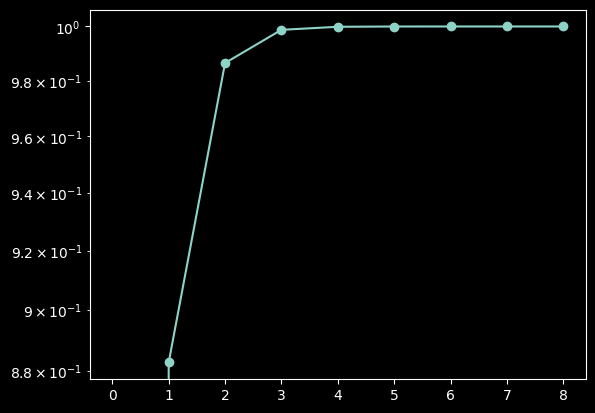

In [22]:
#8.3.1
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

def inviter(A, s, numiter):
    n = A.shape[0]
    x = np.random.randn(n)
    x = x / np.linalg.norm(x)
    beta = np.zeros(numiter)
    B = A - s * np.eye(n)
    PL, U = sp.linalg.lu(B, permute_l=True)

    for i in range(numiter):
        y = np.linalg.solve(U, np.linalg.solve(PL, x))
        alpha = np.dot(x, y)
        beta[i] = (1 / alpha) + s
        x = y / np.linalg.norm(y)

    return beta, x

A = np.array([
    [1.1, 1.],
    [0., 2.1]
])
s = 1
numiter = 10

beta, x = inviter(A, s, numiter)
print(beta)
err = [(beta[k] - s) / (beta[k + 1] - s) for k in range(numiter - 1)]
plt.subplots()
plt.semilogy(np.arange(numiter - 1), err, "-o")
plt.show()

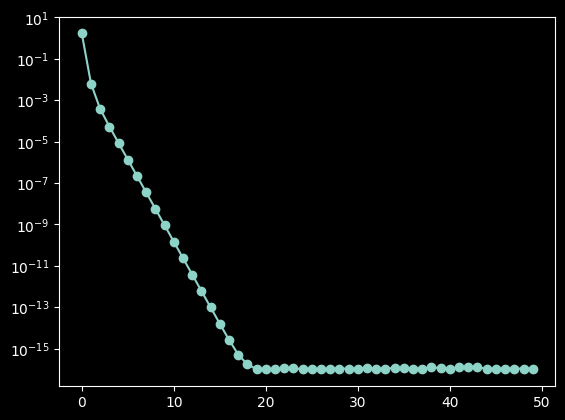

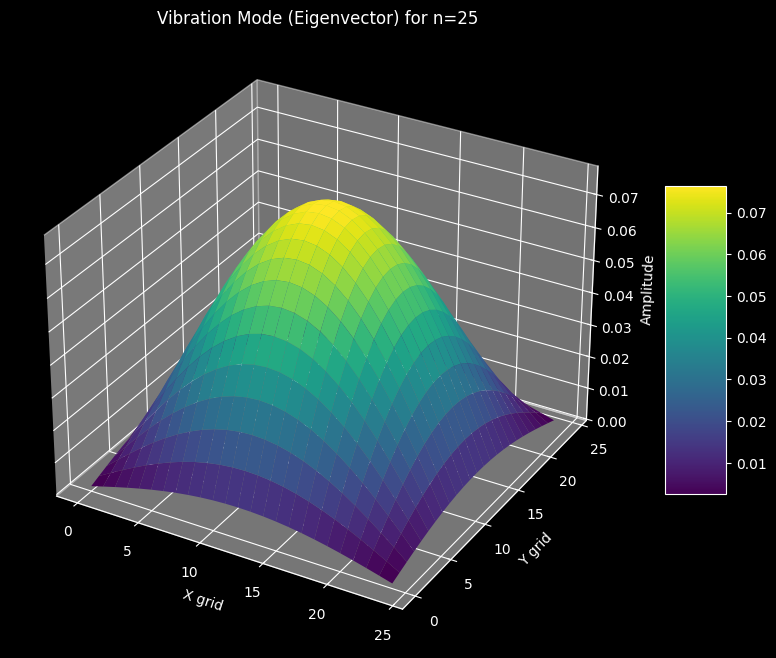

In [60]:
#8.3.5
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def poisson_2d(n):
    """
    构造二维 n*n 网格的离散拉普拉斯矩阵 A (大小 n^2 * n^2)
    这对应于 FNC.poisson(n)
    """
    # 1. 构造一维的算子 T (三对角矩阵)
    # 大小 n * n
    # 这里的 2 和 -1 是数学上的拓扑关系，物理参数(质量/张力)可以在外部乘上去
    data = [np.ones(n)*2, np.ones(n-1)*-1, np.ones(n-1)*-1]
    offsets = [0, 1, -1]
    T = sp.sparse.diags(data, offsets, shape=(n, n), format='csr')

    # 2. 利用 Kronecker Sum 扩展到二维
    # A = T ⊕ T
    # k = 1 (上下左右四个邻居)
    A = sp.sparse.kronsum(T, T, format='csr')

    return A

def inviter(A, s, numiter):
    n = A.shape[0]
    x = np.random.randn(n)
    x = x / np.linalg.norm(x)
    beta = np.zeros(numiter)
    B = A - s * np.eye(n)
    PL, U = sp.linalg.lu(B, permute_l=True)

    for i in range(numiter):
        y = np.linalg.solve(U, np.linalg.solve(PL, x))
        alpha = np.dot(x, y)
        beta[i] = (1 / alpha) + s
        x = y / np.linalg.norm(y)

    return beta, x

s = 0
numiter = 50
n = 25
A = poisson_2d(n)
ev, V = sp.sparse.linalg.eigs(A, k=5, which='SR')
lambda_smallest_act = ev[0]
beta, x = inviter(A, s, numiter)
err = [abs((beta[k] - lambda_smallest_act)) for k in range(numiter)]

plt.subplots()
plt.semilogy(np.arange(numiter), err, "-o")
plt.show()

Z = x.reshape(n, n)

#生成网格坐标
# 我们需要告诉计算机每一个 Z 值对应的 (x, y) 坐标在哪里
x_axis = np.arange(n)
y_axis = np.arange(n)
X, Y = np.meshgrid(x_axis, y_axis)

#绘制 3D 表面图
fig = plt.figure(figsize=(10, 8))       # 创建一个画布
ax = fig.add_subplot(111, projection='3d') # 添加一个3D坐标轴

# X, Y: 地面上的网格坐标
# Z:    高度数据
# cmap: 颜色映射 (viridis 是常用的蓝-黄渐变，很适合表示高低)
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# 添加旁边的颜色条，用来参照数值大小
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# 设置标题和标签
ax.set_title(f"Vibration Mode (Eigenvector) for n={n}")
ax.set_xlabel("X grid")
ax.set_ylabel("Y grid")
ax.set_zlabel("Amplitude")

plt.show()


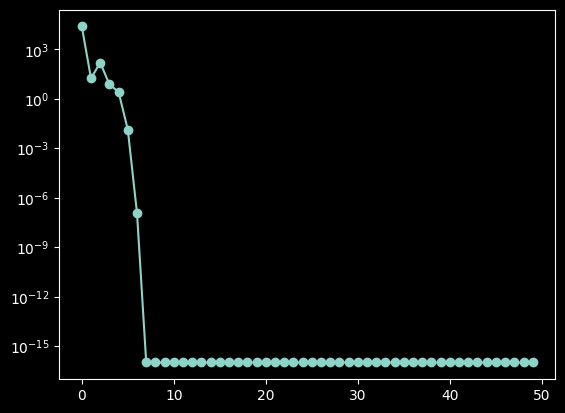

In [85]:
#8.3.6
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

def inviter(A, s, numiter):
    n = A.shape[0]
    x = np.random.randn(n)
    x = x / np.linalg.norm(x)
    beta = np.zeros(numiter)

    for i in range(numiter):
        B = A - s * np.eye(n)
        try:
            PL, U = sp.linalg.lu(B, permute_l=True)
            y = np.linalg.solve(U, np.linalg.solve(PL, x))
        except np.linalg.LinAlgError:

            B = B + np.eye(n) * 1e-14
            PL, U = sp.linalg.lu(B, permute_l=True)
            y = np.linalg.solve(U, np.linalg.solve(PL, x))

        alpha = np.dot(x, y)
        beta[i] = (1.0 / alpha) + s  # 注意用 1.0 浮点数
        s = beta[i]
        x = y / np.linalg.norm(y)

    return beta, x

s = 920 + 1e-4
numiter = 50
data = [np.arange(1, 101)**2, np.random.rand(99)]
offset = [0, 1]
A = sp.sparse.diags(data, offset, format="lil")
A_dense = A.toarray()

lambda_smallest_act = 30**2
beta, x = inviter(A_dense, s, numiter)

err = [abs(beta[k] - lambda_smallest_act) + 1e-16 for k in range(numiter)]
plt.subplots()
plt.semilogy(np.arange(numiter), err, "-o")
plt.show()
